# Experiment 1: Baseline Training and Evaluation

__Objective:__ Train CNN-LSTM model on Flickr8k and evaluate using automatic metrics (BLEU, METEOR, etc.)

__Research Question:__ How accurately do image captioning models preserve the semantic content of an input image?

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from vtt.data.caption_preprocessing import load_tokenizer, load_and_clean_captions
from vtt.data.data_loader import load_split_datasets
from vtt.models.decoder import build_decoder_model
from vtt.models.train import train_model
from vtt.models.predict import display_images_with_greedy_captions, display_images_with_beam_captions
from vtt.visualization.history_plot import plot_training_history
from vtt.evaluation.evaluate import evaluate_model_greedy, evaluate_model_beam

/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paths

In [4]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.json"
captions_file = f"../data/raw/{dataset_name}_captions.csv"

## Load Tokenizer and Features

In [5]:
tokenizer = load_tokenizer(tokenizer_path)
features = np.load(features_path)

[INFO] Tokenizer loaded from JSON file: ../data/processed/flickr8k_tokenizer.json


## Load Datasets

In [6]:
train_ds, val_ds, test_ds = load_split_datasets(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=64,
    val_split=0.15,
    test_split=0.10,
    shuffle=True,
    buffer_size=1000,
    seed=42,
    cache=True,
    return_numpy=False
)


--- Dataset Split Sizes (number of individual samples) ---
Total samples loaded: 38008
Train samples: 28507
Validation samples: 5701
Test samples: 3800
----------------------------------------------------------



## Build Model

In [8]:
# Get max caption length from dataset
for (image_tensor, input_caption, _), _ in train_ds.take(1):
    max_caption_len = input_caption.shape[1]
# Get vocab size
vocab_size = tokenizer.num_words

model = build_decoder_model(vocab_size=vocab_size, max_caption_len=max_caption_len)
model.summary()

2025-07-18 22:42:27.499694: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-18 22:42:27.500368: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "ImageCaptionDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_image        │ (None, 1, 256)    │          0 │ image_dense[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_image_caption │ (None, 19, 256)   │          0 │ expand_image[0][… │
│ (Concatenate)       │                   │            │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ merge_image_capt… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trim_image_output   │ (None, 18, 10000) │          0 │ output_dense[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
# Train model
history = train_model(
    dataset=train_ds,
    model=model,
    epochs=25,
    val_dataset=val_ds,
    checkpoint_path="../models/flickr8k_decoder_weights.weights.h5",
    early_stop_patience=5,
)

Epoch 1/25


2025-07-16 12:44:53.588828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 2.3329
Epoch 1: val_loss improved from inf to 2.15353, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 375ms/step - loss: 2.3327 - val_loss: 2.1535
Epoch 2/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 2.1180
Epoch 2: val_loss improved from 2.15353 to 2.03975, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 166s 374ms/step - loss: 2.1179 - val_loss: 2.0397
Epoch 3/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.9947
Epoch 3: val_loss improved from 2.03975 to 1.96670, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 376ms/step - loss: 1.9946 - val_loss: 1.9667
Epoch 4/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.9003
Epoch 4: val_loss improved from 1.96670 to 1.91423, saving model to ../models/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 167s 375ms/step -

## Save Trained Model

In [38]:
save_path = "../models/flickr8k_decoder_model.keras"
model.save(save_path)

## Plot Training History

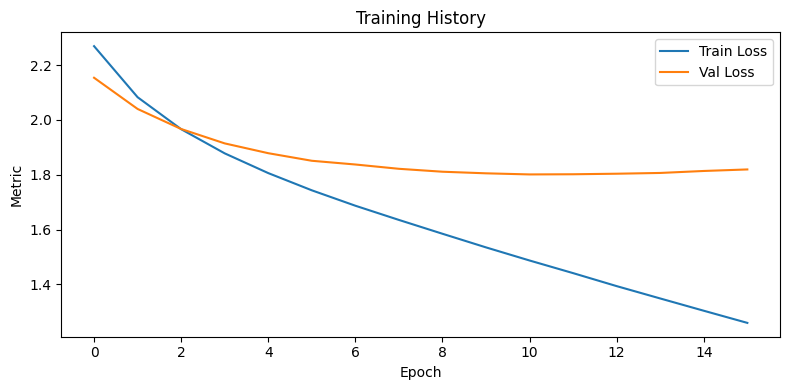

In [39]:
# New plot
plot_training_history(history, metrics=["loss"])

## Load the saved Model Weights

In [9]:
model = build_decoder_model(vocab_size=vocab_size,
                            max_caption_len=max_caption_len)

checkpoint_path = "../models/flickr8k_decoder_weights.weights.h5"
model.load_weights(checkpoint_path)
print("Loaded pretrained weights")


Loaded pretrained weights


/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluate Model on Test Set

### Evaluate Scores for Test Dataset using Greedy Caption Generation

In [ ]:
references_dict = load_and_clean_captions(f"../data/raw/{dataset_name}_captions.csv")

scores_greedy = evaluate_model_greedy(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=test_ds,
    references_dict=references_dict,
    max_len=max_caption_len,
)

Generating Captions from Dataset: 100%|██████████| 60/60 [24:35<00:00, 24.58s/it]
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0717 21:54:37.248000 45285 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Greedy Caption generation

In [ ]:
print("Evaluation Scores:")
for metric, score in scores_greedy.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.4705
BLEU-2: 0.2836
BLEU-3: 0.1710
BLEU-4: 0.1126
METEOR: 0.2661
BERTScore_P: 0.8854
BERTScore_R: 0.8552
BERTScore_F1: 0.8699


### Evaluate Scores for Test Dataset using Beam Search

In [87]:
scores_beam = evaluate_model_beam(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=test_ds,
    references_dict=references_dict,
    max_len=max_caption_len,
    beam_width=5
)

Evaluating: 100%|██████████| 60/60 [2:03:19<00:00, 123.33s/it]  
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Caption generation using Beam Search

In [88]:
print("Evaluation Scores:")
for metric, score in scores_beam.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.4712
BLEU-2: 0.2865
BLEU-3: 0.1778
BLEU-4: 0.1199
METEOR: 0.2675
BERTScore_P: 0.8906
BERTScore_R: 0.8552
BERTScore_F1: 0.8725


## Predict Sample Captions from Test Set

In [20]:
import random

# Step 1: Unbatch and collect all image IDs from test_ds
all_image_ids = [img_id.numpy().decode('utf-8') for (_, _, img_id), _ in test_ds.unbatch()]

# Step 2: Sample 5 random IDs
sample_image_ids = random.sample(all_image_ids, 5)


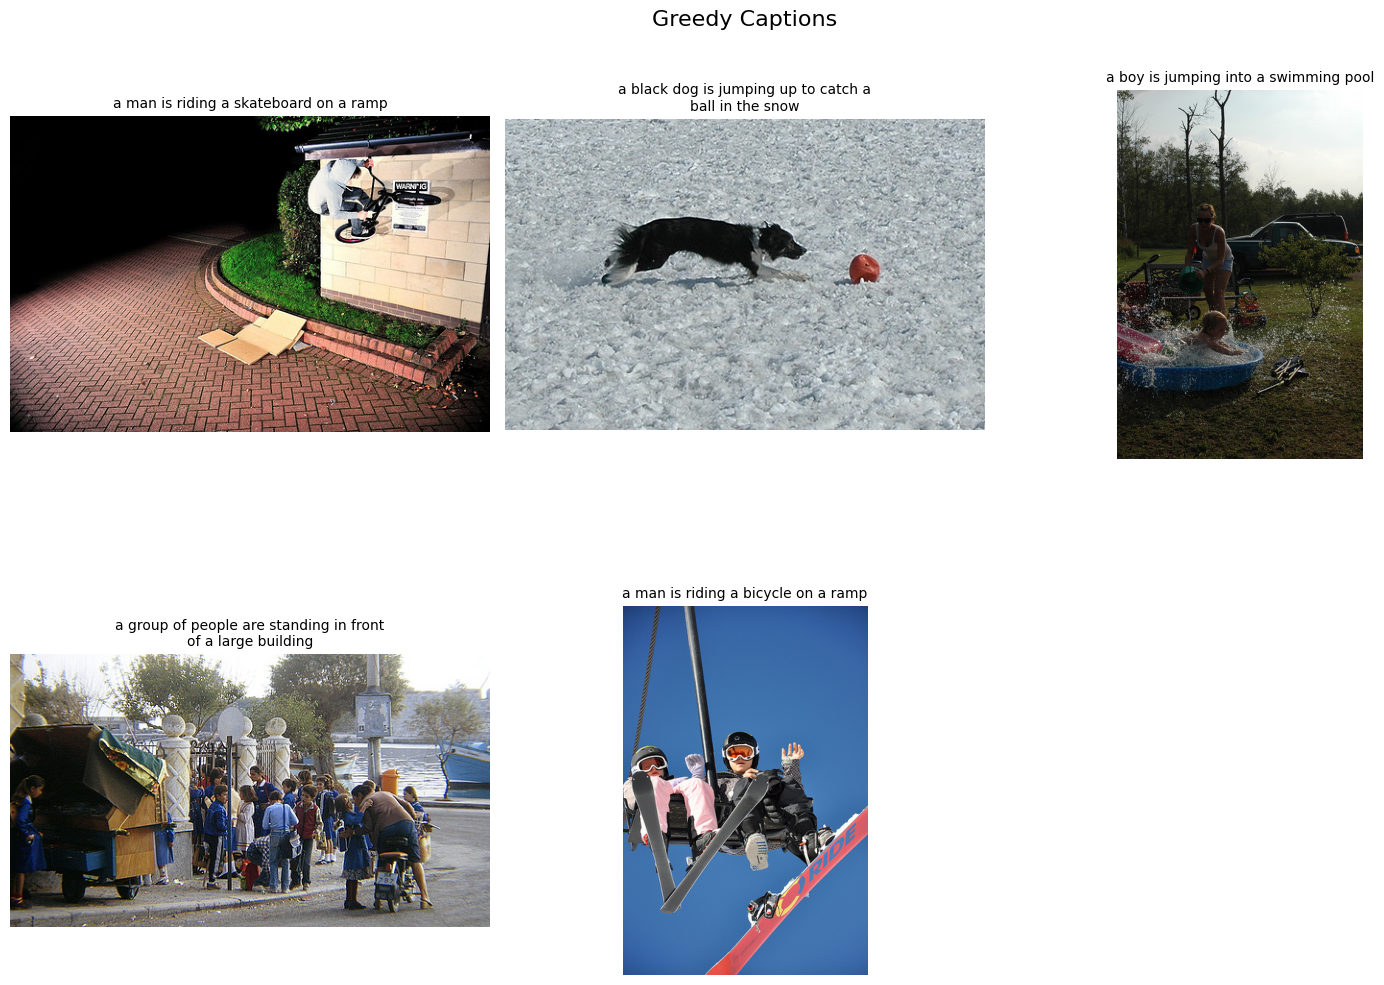

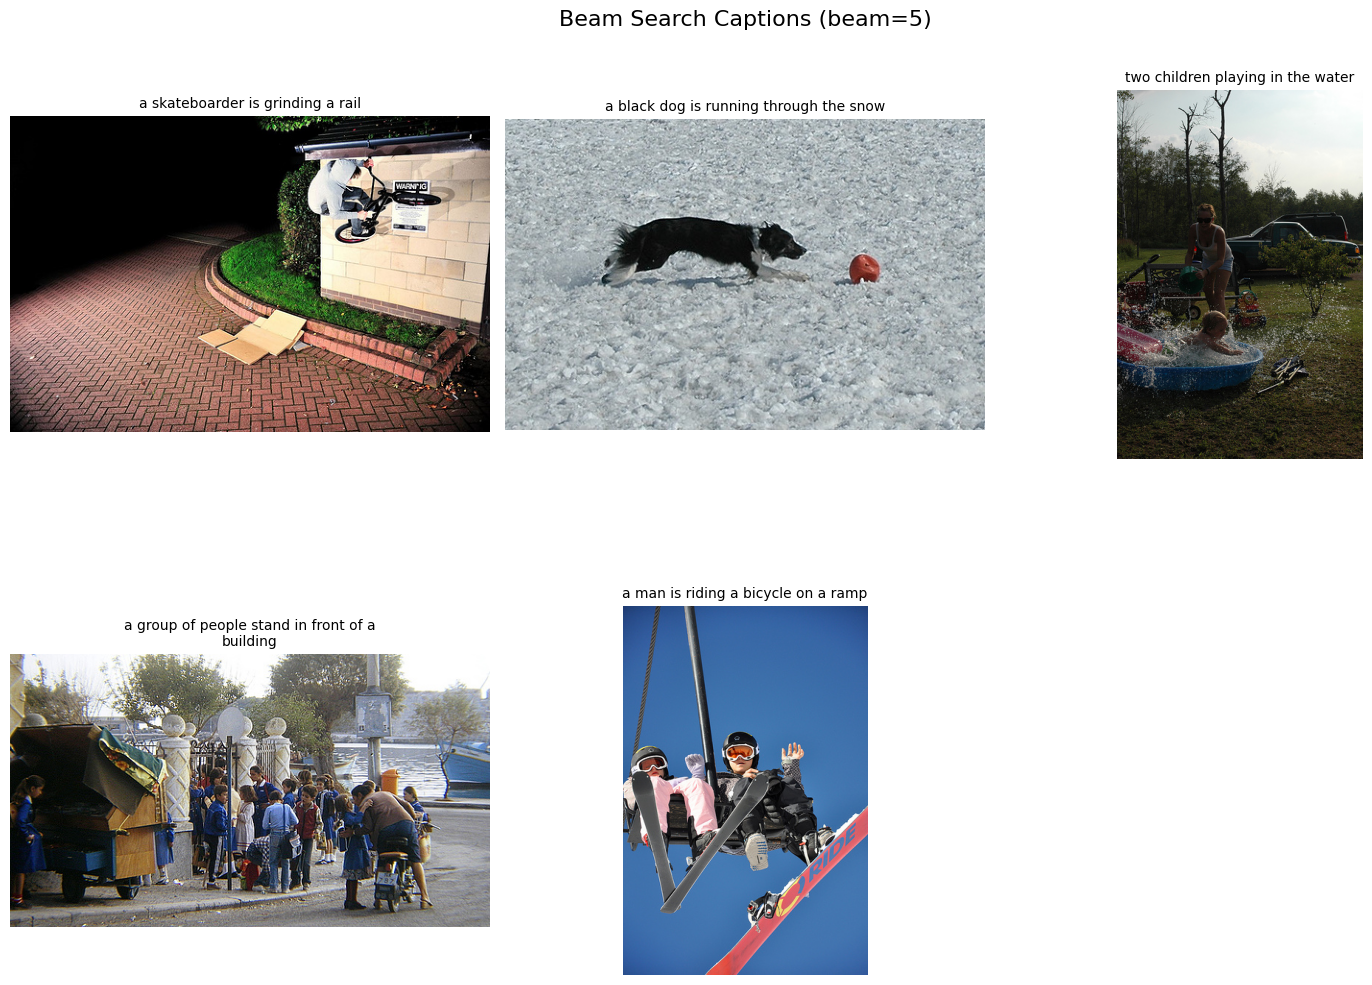

In [21]:
image_folder = "../data/flickr8k_images_dataset/Images"

# Step 3: Call display_images_with_captions
display_images_with_greedy_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder
)

display_images_with_beam_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder,
    beam_width=5,
    max_len=max_caption_len,
    cols=3,
)
